In [107]:
import re

import pandas as pd
import numpy as np

import geopandas as gpd
import geojson

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', 1000)
sns.set_style("darkgrid", {"axes.facecolor": ".8"})

## VISUALIZE ARTURO MODEL (Already cleaned)

El modelo de arturo.300000kms.net está dividido en dos JSON:
>- datos de entrenamiento en json con columnas value y dm_id
>- modelo de datos urbanísticos en geojson

In [111]:
arturo_path = '../data/raw/arturo' # arturo_modelo.json & model.geojson

with open(f"{arturo_path}/arturo_modelo.json") as f:
    arturo_json = geojson.load(f)
    # list of dict with keys: value and dm_id
    
urban_df = gpd.read_file(f"{arturo_path}/model.geojson")

EDA de datos de entrenamiento

In [112]:
arturo_json_pd = pd.DataFrame(arturo_json)

display(arturo_json_pd.head(10).T)
display(arturo_json_pd.info())

print(f"Unique values in value col: \t {arturo_json_pd['value'].nunique()*100/arturo_json_pd['value'].size}")
print(f"Unique values in dm_id col: \t {arturo_json_pd['dm_id'].nunique()*100/arturo_json_pd['dm_id'].size}")

# en ambas columnas sólo hay valores únicos
# dm_id es la col que conecta con el geojson
# value es el valor de calidad votado por los ciudadanos

,0,1,2,3,4,5,6,7,8,9
value,21.0104,20.2034,15.743,17.2082,15.0262,21.5883,16.4932,23.359,27.0116,25.6708
dm_id,1001,10015,10069,10070,10072,10075,10087,10093,10102,10105


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465 entries, 0 to 5464
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   5465 non-null   float64
 1   dm_id   5465 non-null   object 
dtypes: float64(1), object(1)
memory usage: 85.5+ KB


None

Unique values in value col: 	 100.0
Unique values in dm_id col: 	 100.0


In [113]:
arturo_json_pd['dm_id_num'] = pd.to_numeric(arturo_json_pd['dm_id'], downcast = 'integer')

print(f"Range in value col: \t [{arturo_json_pd['value'].min()},  {arturo_json_pd['value'].max()}]")
print(f"Range in dm_id col: \t [{arturo_json_pd['dm_id_num'].min()},  {arturo_json_pd['dm_id_num'].max()}]")
# valores dm_id y value no están georeferenciados 

Range in value col: 	 [6.447847761767921,  42.57460885029834]
Range in dm_id col: 	 [25,  66506]


Los datos de geojson son un conjunto de indicadores empleados para entrenar el modelo de Arturo, geolocalizados a través del viario de Madrid (se desconoce el año del callejero 2019 ó 2019) y la col dm_id

In [114]:
## añadir columna de valoraciones de la calidad del esp publico en df
arturo_sorted = arturo_json_pd.set_index('dm_id').sort_values(by = 'dm_id')
urban_df = urban_df.join(arturo_sorted, on = 'dm_id')

display(urban_df.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 66499 entries, 0 to 66498
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OGC_FID                        66499 non-null  object  
 1   geom_pu                        66499 non-null  object  
 2   dist_barri                     66483 non-null  object  
 3   dm_id                          66499 non-null  object  
 4   train                          66499 non-null  int64   
 5   land_use_mix                   66499 non-null  float64 
 6   closeness_small_parks          66499 non-null  float64 
 7   residence_ratio                66499 non-null  float64 
 8   block_area                     66499 non-null  float64 
 9   intersection_density           66499 non-null  float64 
 10  anisotropicity                 66499 non-null  float64 
 11  average_age                    66499 non-null  float64 
 12  age_diversity           

None

In [115]:
# vistazo a columnas que no sé qué son
display(urban_df[['OGC_FID', 'geom_pu', 'dist_barri', 'dm_id', 'average_quality', 'pk', 'geometry']].head())

# OGC_FID y pk son indexes
display(urban_df[['OGC_FID', 'dm_id', 'pk']].tail(19).T)

,OGC_FID,geom_pu,dist_barri,dm_id,average_quality,pk,geometry
0,1,SRID=25830;POINT(444133.736820226 4482808.8916...,1606,1,3.277406,1,"MULTILINESTRING ((-3.65969 40.49369, -3.65882 ..."
1,2,SRID=25830;POINT(444192.038205298 4482878.0294...,1606,2,3.113298,2,"MULTILINESTRING ((-3.65833 40.49494, -3.65848 ..."
2,3,SRID=25830;POINT(444134.537506681 4482885.3751...,1606,3,3.143822,3,"MULTILINESTRING ((-3.65969 40.49506, -3.65882 ..."
3,4,SRID=25830;POINT(445612.690578458 4479335.7195...,1603,4,5.740980,4,"MULTILINESTRING ((-3.64155 40.46301, -3.64146 ..."
4,5,SRID=25830;POINT(445606.319326282 4479354.4426...,1603,5,5.468163,5,"MULTILINESTRING ((-3.64161 40.46315, -3.64155 ..."


,66480,66481,66482,66483,66484,66485,66486,66487,66488,66489,66490,66491,66492,66493,66494,66495,66496,66497,66498
OGC_FID,66481,66482,66483,66484,66485,66486,66487,66488,66489,66490,66491,66492,66493,66494,66495,66496,66497,66498,66499
dm_id,66505,66506,66507,66508,66509,66510,66511,66512,66513,66514,66515,66516,66517,66518,66519,66520,66521,66522,66523
pk,66481,66482,66483,66484,66485,66486,66487,66488,66489,66490,66491,66492,66493,66494,66495,66496,66497,66498,66499


### NEW DF WITH GEOMETRIES OF POINTS

In [116]:
urban_df.drop(['geometry'], axis = 1, inplace = True)

urban_df['geom_point'] = urban_df.apply(lambda x: x['geom_pu'].split(';')[1], axis = 1)
urban_df['point_list'] = urban_df.apply(lambda x: re.findall(r'\d+', x['geom_point']), axis = 1)

urban_df['point_x'] = urban_df.apply(lambda x: float(str(x['point_list'][0]) +'.'+ str(x['point_list'][1])), axis = 1)
urban_df['point_y'] = urban_df.apply(lambda x: float(str(x['point_list'][2]) +'.'+ str(x['point_list'][3])), axis = 1)

In [117]:
urban_point_df = gpd.GeoDataFrame(
        urban_df, geometry = gpd.points_from_xy(urban_df['point_x'], urban_df['point_y']))

In [118]:
urban_point_df.drop(['point_list', 'geom_point', 'point_x', 'point_y', 'geom_pu'], axis = 1, inplace = True)

In [119]:
# FIRST DISPLAY OF NANs
display(urban_point_df.shape[0])
display(urban_point_df['value'].isna().sum())
display(urban_point_df['value'].notnull().sum())
print(f"Percentage of Nulls: {urban_point_df['value'].isna().sum()*100 / urban_point_df.shape[0]}")

66499

61034

5465

Percentage of Nulls: 91.78183130573392


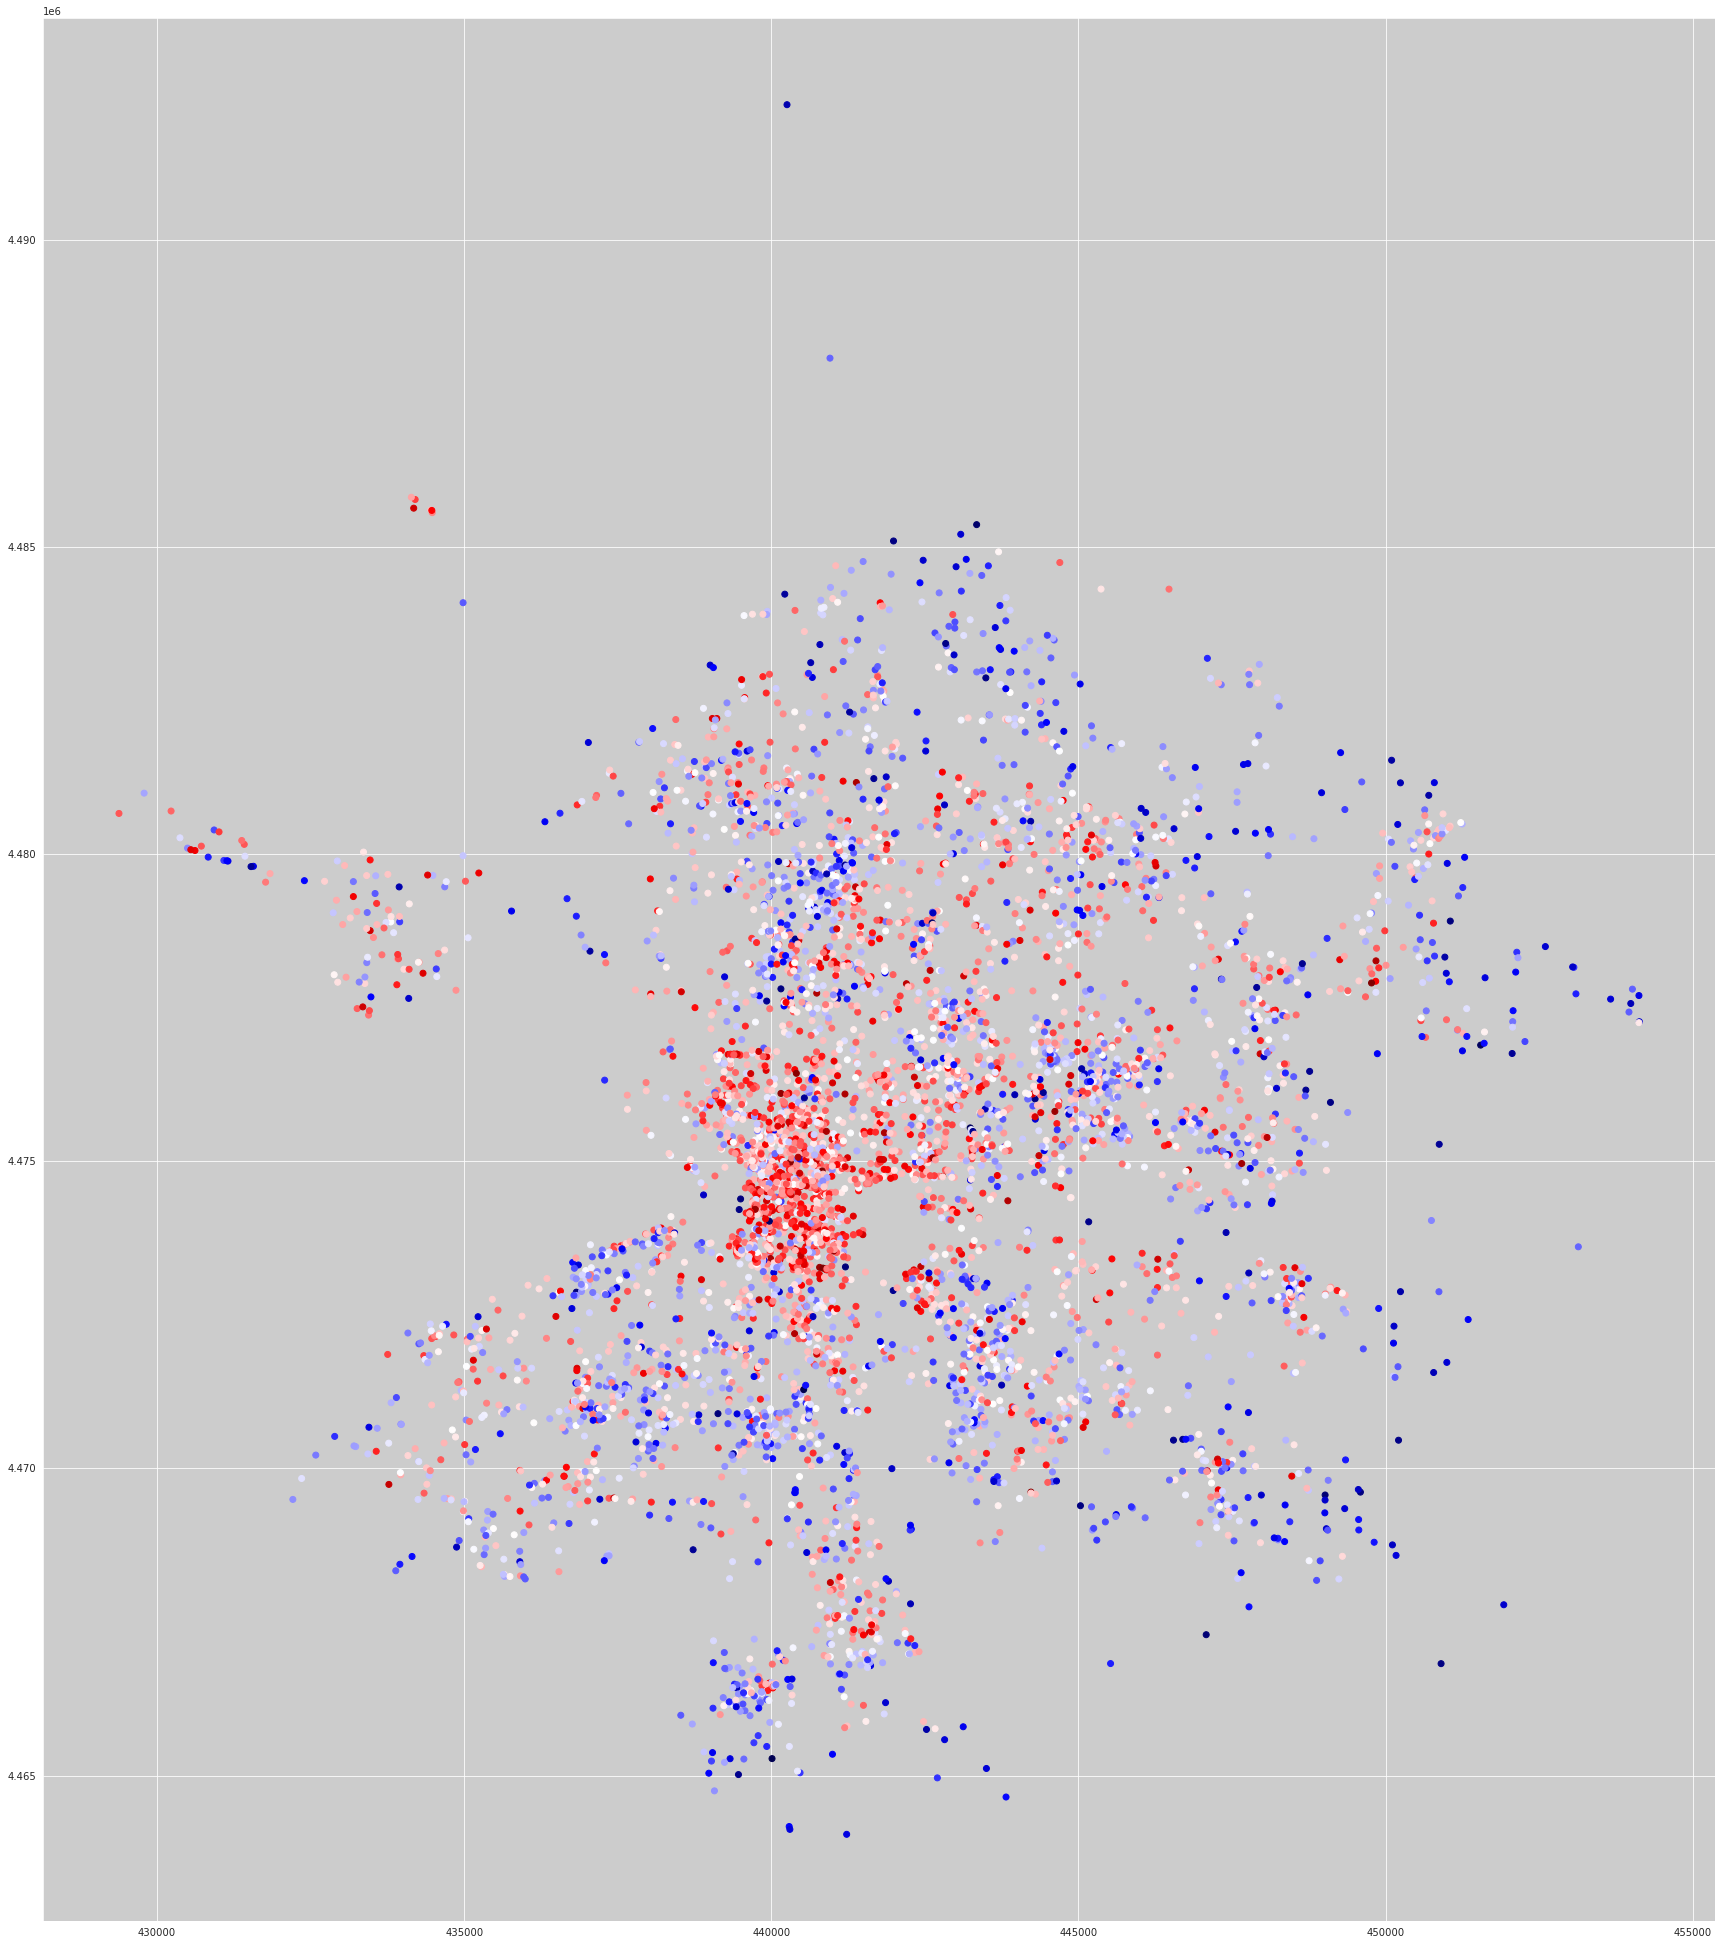

In [120]:
# DRAWING
col_to_draw = 'value'
urban_point_df[['geometry', col_to_draw]].plot(figsize = (35,35), 
                                               column = col_to_draw, 
                                               legend = False,
                                               cmap = 'seismic')
plt.show()

In [121]:
urban_point_df[['dm_id', 'dist_barri', 'value', 'dm_id_num', 'geometry']].isna().sum() 
# solo muestro estas columnas al haber un porrón y sólo haber nulls en algunas de estas

dm_id             0
dist_barri       16
value         61034
dm_id_num     61034
geometry          0
dtype: int64

## GRADIENT BOOSTING

In [122]:
# Separating nulls into two dataframes

arturo_notnan = urban_point_df[urban_point_df['value'].notnull()]
display(arturo_notnan.head(2))
display(arturo_notnan.shape)

arturo_isnan = urban_point_df[urban_point_df['value'].isna()]
display(arturo_isnan.head(2))
display(arturo_isnan.shape)

,OGC_FID,dist_barri,dm_id,train,land_use_mix,closeness_small_parks,residence_ratio,block_area,intersection_density,anisotropicity,...,street_centrality_eigenvector,street_centrality_betweenness,street_centrality_closeness,street_hierarchy_primary,street_hierarchy_secondary,street_hierarchy_tertiary,pk,value,dm_id_num,geometry
24,25,0106,25,1,0.000367,0.000000,0.392077,777.088889,0.904328,0.042223,...,0.0,0.000087,0.014667,0,0,1,25,18.879817,25.0,POINT (440078.047 4474416.418)
34,35,1102,35,1,0.000279,1.354545,0.438556,375.867925,0.683260,0.032681,...,0.0,0.000021,0.017378,0,1,0,35,25.393770,35.0,POINT (438259.778 4470960.124)


(5465, 60)

,OGC_FID,dist_barri,dm_id,train,land_use_mix,closeness_small_parks,residence_ratio,block_area,intersection_density,anisotropicity,...,street_centrality_eigenvector,street_centrality_betweenness,street_centrality_closeness,street_hierarchy_primary,street_hierarchy_secondary,street_hierarchy_tertiary,pk,value,dm_id_num,geometry
0,1,1606,1,2,0.000033,500.0,0.805184,3421.333333,0.303332,0.251938,...,0.0,0.000093,0.017458,0,0,1,1,NaN,NaN,POINT (444133.737 4482808.892)
1,2,1606,2,0,0.000041,500.0,0.848557,2780.800000,0.337187,0.233228,...,0.0,0.000174,0.017685,0,0,1,2,NaN,NaN,POINT (444192.038 4482878.029)


(61034, 60)

In [123]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# preparing the data
cat_cols = ['dm_id', 'dm_id_num', 'dist_barri', 'OGC_FID', 'pk', 'geometry', 'value']
NUM_FEATS = [col for col in arturo_notnan.columns if col not in cat_cols]
TARGET = 'value'

# numeric preprocessing
numeric_transformer = \
Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                   ('scaler', StandardScaler())])

# i am choosing not to take into account categorical values since
# dm_id, dm_id_num, OGC_FID, pk  --> IDs, therefore not really information
# geomtry and dist_barri are useful but no for this

preprocessor = \
ColumnTransformer( transformers = [('num', numeric_transformer, NUM_FEATS)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['train', 'land_use_mix',
                                  'closeness_small_parks', 'residence_ratio',
                                  'block_area', 'intersection_density',
                                  'anisotropicity', 'average_age',
                                  'age_diversity', 'age_deviation_diversity',
                                  'built_density', 'population_density',
                                  'ocasion...
                                  'leisure_density', 'educational_density',
                                  'nightlife_density', 'culture_density',
                                  'closeness_large_parks',
                                  'closeness_primar

In [124]:
from sklearn.model_selection import train_test_split

X_data = arturo_notnan[NUM_FEATS]
Y_data = arturo_notnan[TARGET]

x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data,
                                                    random_state = 42,
                                                    test_size = 0.25)

display(x_train.shape); display(x_test.shape)
display(y_train.shape); display(y_test.shape)

(4098, 53)

(1367, 53)

(4098,)

(1367,)

In [125]:
# !!!!!!!!!!!!!!!!!!!!
import lightgbm

# Create LightGBM data containers
train_data = lightgbm.Dataset(x_train, label = y_train)
test_data  = lightgbm.Dataset(x_test,  label = y_test)

parameters = {
    'objective'   : 'regression',
    'boosting_type' : 'gbdt',
    'metric'      : 'rmse',
    'is_unbalance': 'true',
    'boosting'    : 'gbdt',
    'num_leaves'  : 10, # Default 31
    'feature_fraction' : 0.5,
    'bagging_fraction' : 0.2,
    'baggin_freq' : 100,
    'learning_rate' : 0.1,
    'verbose'     : 0
            }


model_gb = lightgbm.train(parameters,
                          train_data,
                          valid_sets = test_data,
                          num_boost_round = 2500,  # DEFAULT 100
                          early_stopping_rounds = 250)

[1]	valid_0's rmse: 5.47231
Training until validation scores don't improve for 250 rounds
[2]	valid_0's rmse: 5.39432
[3]	valid_0's rmse: 5.33205
[4]	valid_0's rmse: 5.27
[5]	valid_0's rmse: 5.22253
[6]	valid_0's rmse: 5.18125
[7]	valid_0's rmse: 5.14996
[8]	valid_0's rmse: 5.11703
[9]	valid_0's rmse: 5.09551
[10]	valid_0's rmse: 5.06468
[11]	valid_0's rmse: 5.04716
[12]	valid_0's rmse: 5.02768
[13]	valid_0's rmse: 5.01106
[14]	valid_0's rmse: 4.99833
[15]	valid_0's rmse: 4.98701
[16]	valid_0's rmse: 4.97508
[17]	valid_0's rmse: 4.96326
[18]	valid_0's rmse: 4.95311
[19]	valid_0's rmse: 4.94246
[20]	valid_0's rmse: 4.93894
[21]	valid_0's rmse: 4.93673
[22]	valid_0's rmse: 4.93416
[23]	valid_0's rmse: 4.93079
[24]	valid_0's rmse: 4.92549
[25]	valid_0's rmse: 4.92214
[26]	valid_0's rmse: 4.91793
[27]	valid_0's rmse: 4.91446
[28]	valid_0's rmse: 4.91038
[29]	valid_0's rmse: 4.90964
[30]	valid_0's rmse: 4.90374
[31]	valid_0's rmse: 4.90204
[32]	valid_0's rmse: 4.9009
[33]	valid_0's rmse: 4.

[287]	valid_0's rmse: 4.90471
[288]	valid_0's rmse: 4.90434
[289]	valid_0's rmse: 4.90407
[290]	valid_0's rmse: 4.90682
[291]	valid_0's rmse: 4.90736
[292]	valid_0's rmse: 4.90786
[293]	valid_0's rmse: 4.90858
[294]	valid_0's rmse: 4.90959
[295]	valid_0's rmse: 4.90929
[296]	valid_0's rmse: 4.91102
[297]	valid_0's rmse: 4.91076
[298]	valid_0's rmse: 4.91009
[299]	valid_0's rmse: 4.91076
[300]	valid_0's rmse: 4.91016
[301]	valid_0's rmse: 4.91058
[302]	valid_0's rmse: 4.91126
[303]	valid_0's rmse: 4.91329
[304]	valid_0's rmse: 4.91436
[305]	valid_0's rmse: 4.91444
[306]	valid_0's rmse: 4.91529
[307]	valid_0's rmse: 4.91604
[308]	valid_0's rmse: 4.9156
[309]	valid_0's rmse: 4.91587
[310]	valid_0's rmse: 4.91602
[311]	valid_0's rmse: 4.91758
[312]	valid_0's rmse: 4.91735
Early stopping, best iteration is:
[62]	valid_0's rmse: 4.86862


In [126]:
## metrics
from sklearn.metrics import mean_squared_error

y_test_pred = model_gb.predict(x_test)
y_train_pred = model_gb.predict(x_train)

print(f" test error: {mean_squared_error(y_pred = y_test_pred, y_true = y_test, squared = False)}")
print(f" train error: {mean_squared_error(y_pred = y_train_pred, y_true = y_train, squared = False)}")

 test error: 4.868620833034507
 train error: 4.28293293250147


In [127]:
more_values = model_gb.predict(arturo_isnan[NUM_FEATS])

display(len(more_values) == arturo_isnan.shape[0]) # if both lengths are the same -> adding a new column
display(pd.Series(data = more_values, copy = False).isna().sum()) # thereshouldnt be any NaNa

# Adding a new column
arturo_isnan['value'] = more_values.tolist()

True

0

/home/lucia/miniconda3/envs/geoesp_env/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [128]:
display(more_values); display(len(more_values))
display(np.array(arturo_isnan['value'])); display(len(np.array(arturo_isnan['value'])))

array([24.55007748, 24.33528531, 23.19901072, ..., 25.52891773,
       25.62052261, 25.67360959])

61034

array([24.55007748, 24.33528531, 23.19901072, ..., 25.52891773,
       25.62052261, 25.67360959])

61034

In [129]:
arturo_all = pd.concat([arturo_notnan, arturo_isnan])

In [130]:
# SECOND DISPLAY OF NANS
print(f"Shape: \t\t\t\t{arturo_all.shape[0]}")
print(f"Remaining nulls : \t\t{arturo_all['value'].isna().sum()}")

print(f"Not-null data : \t\t{arturo_all['value'].notnull().sum()}")
print(f"Percentage of Nulls: \t\t{arturo_all['value'].isna().sum()*100 / urban_point_df.shape[0]}")

Shape: 				66499
Remaining nulls : 		0
Not-null data : 		66499
Percentage of Nulls: 		0.0


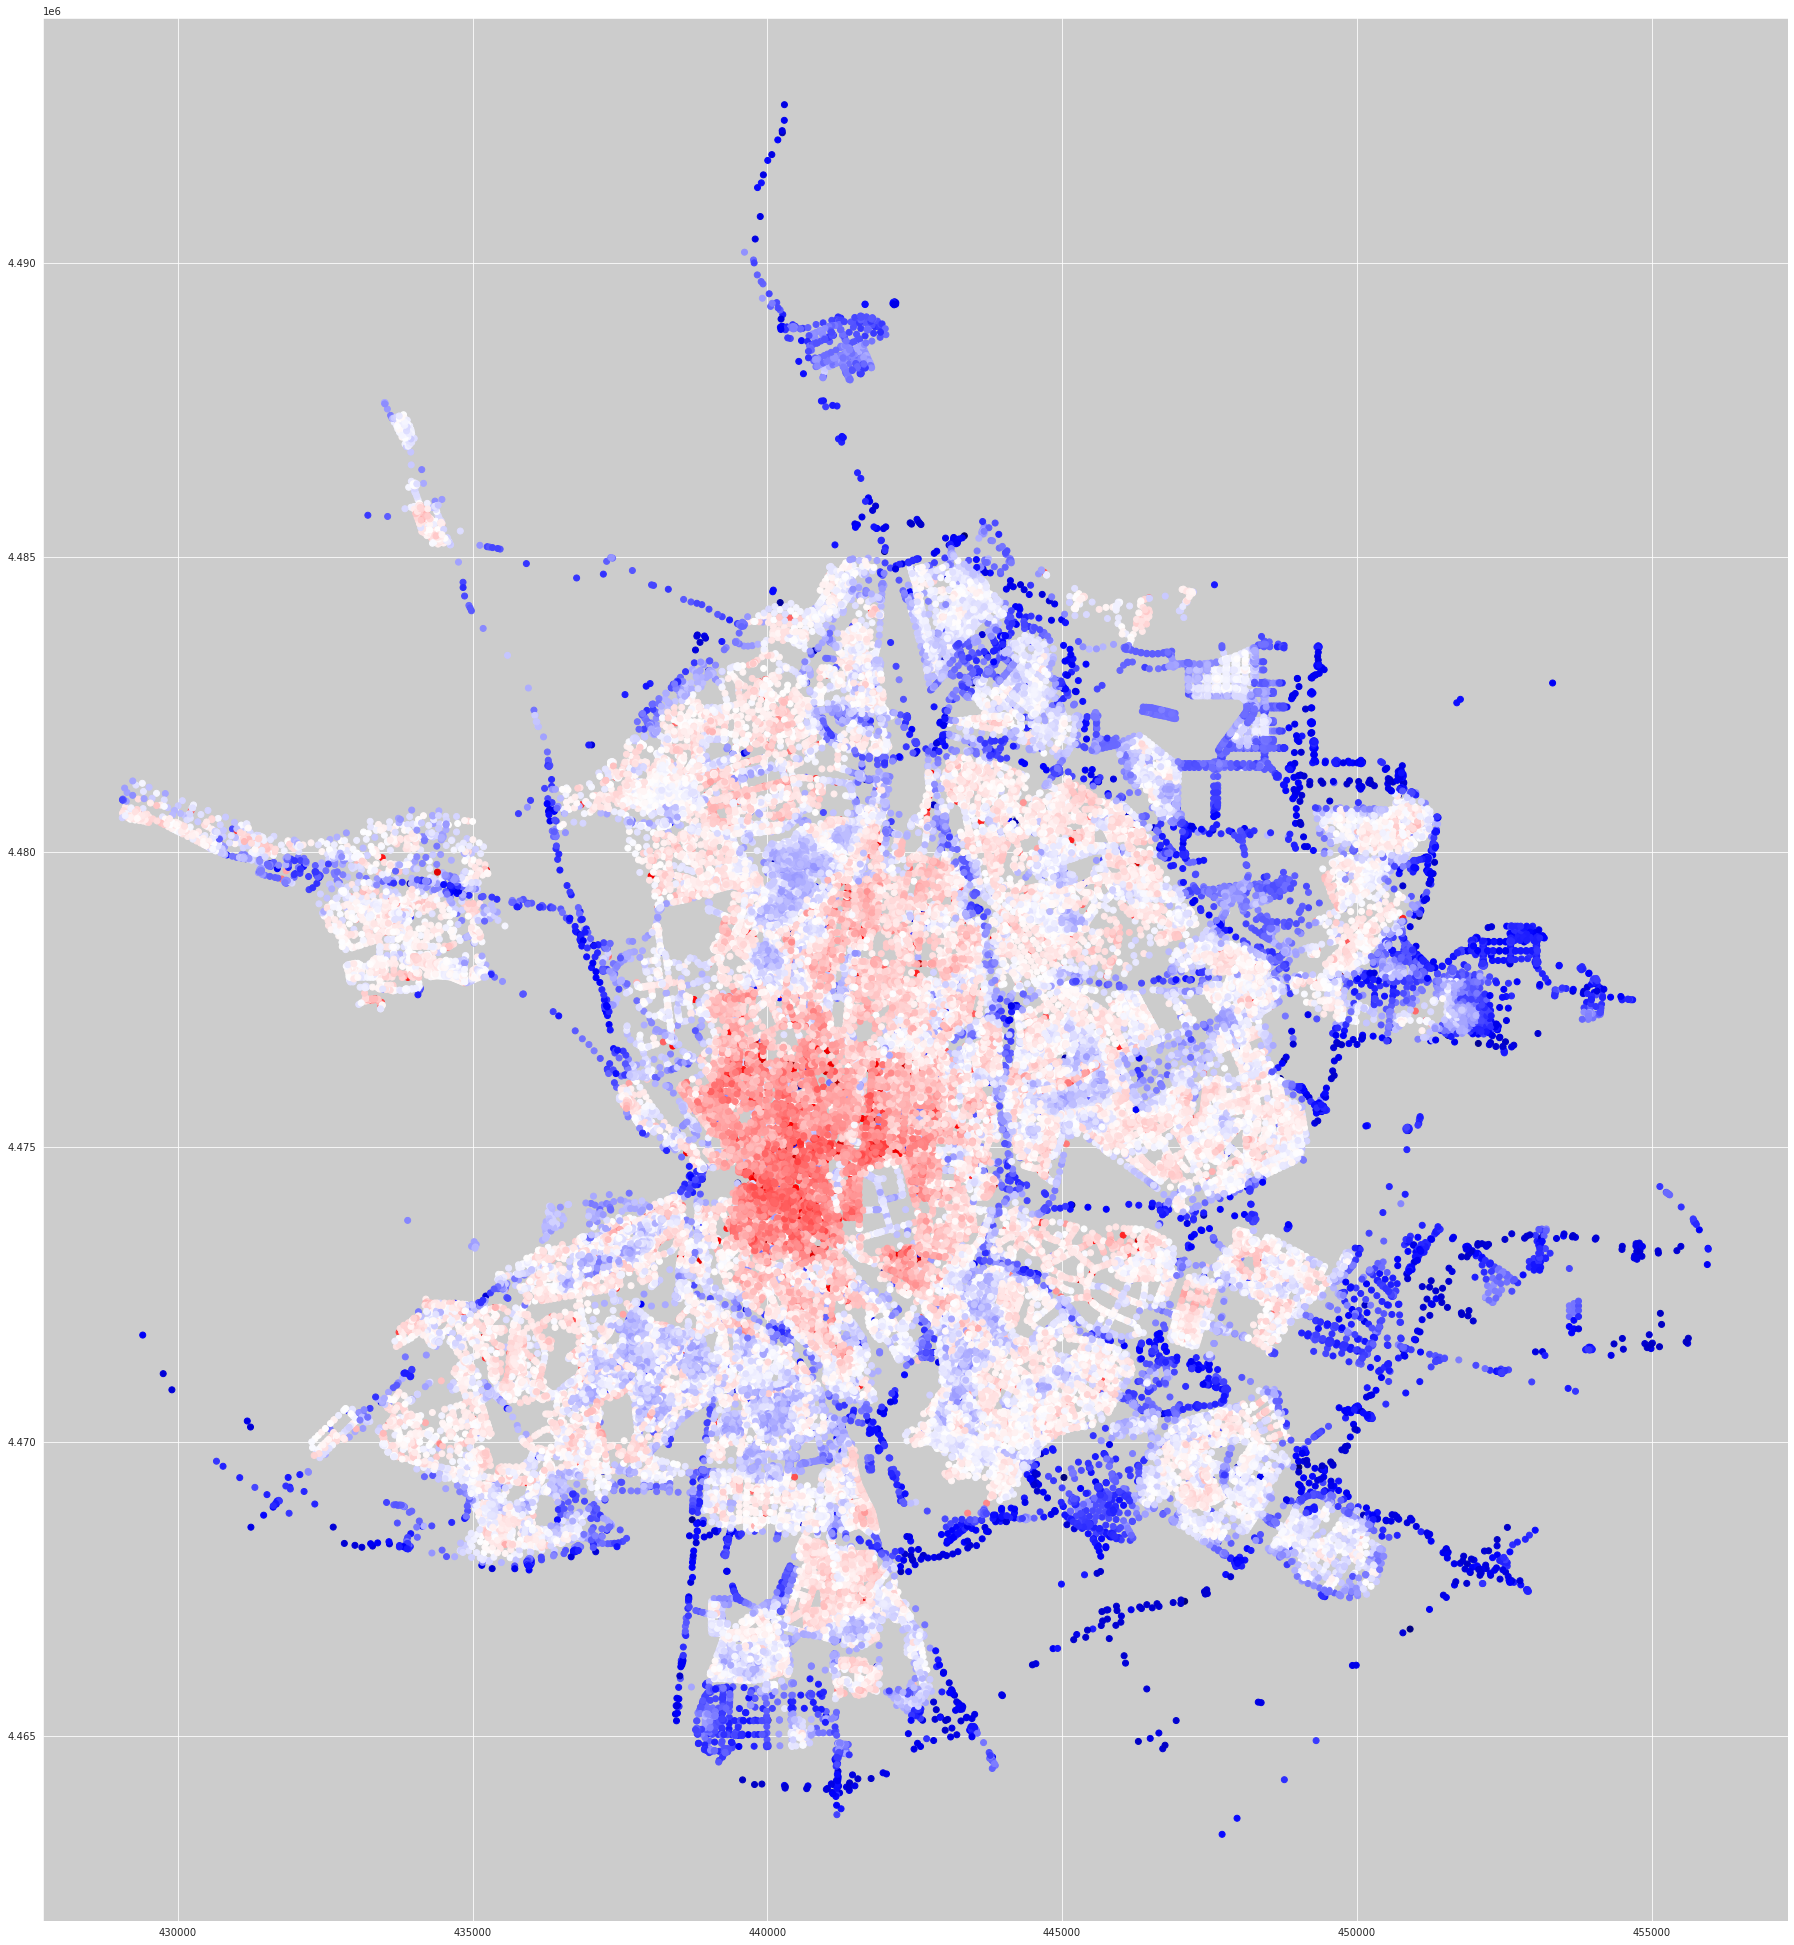

In [132]:
# DRAWING
col_to_draw = 'value'
arturo_all[['geometry', col_to_draw]].plot(figsize = (35,35), 
                                           column = col_to_draw, 
                                           legend = False,
                                           cmap = 'seismic')
plt.show()

### FILTER NANS AND SAVE

In [133]:
arturo_all['geometry'] = arturo_all['geometry'].set_crs("EPSG:25830")
display(arturo_all['geometry'].crs)

<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - 6°W to 0°W and ETRS89 by country
- bounds: (-6.0, 35.26, 0.0, 80.53)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [134]:
CLEAN_PATH = '../data/clean'
arturo_all.to_file(f"{CLEAN_PATH}/arturo.geojson", driver='GeoJSON')